Ture R. Carlson
Khoury College of Computer Sciences
CS6140 - Machine Learning
Northeastern University - Spring 2024
Final Project

# 

In [1]:
# Import Libraries
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Disable warinings
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import librosa
from matplotlib import pyplot as plt
from IPython.display import Audio
import time
import datetime



In [2]:
# Check Versions
import sys
print(f"Python Version: {str(sys.version_info)}")
print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Librosa Version: {librosa.__version__}")

Python Version: sys.version_info(major=3, minor=11, micro=0, releaselevel='candidate', serial=1)
Tensorflow Version: 2.16.1
Keras Version: 3.0.5
Librosa Version: 0.10.1


In [3]:
# Display physical divices (ensure GPU is available to tensorflow)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Setting Random Seeds for Reproducability
RANDOM_SEED=720
keras.utils.set_random_seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [5]:
# Extract RAVDESS Dataset
# Download from https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio and place in ./data as 'RAVDESS.zip'
try:
    data_files = os.listdir("data")
    print(data_files)
    if "RAVDESS" not in data_files:
        print("need to unzip")
        ravdess_path = "/data/" + data_files[0]
        import zipfile
        with zipfile.ZipFile("data/" + "RAVDESS.zip", 'r') as zip_ref:
            print("unzipping....")
            zip_ref.extractall("data/RAVDESS")
        print("Extraction Complete")
except:
    print("download data from https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio and place in ./data as 'RAVDESS.zip'")

['.ipynb_checkpoints', 'RAVDESS', 'RAVDESS.zip']


In [6]:
# Data Preparation -- RAVDESS

# Import file information
path_RAVDESS = "data/RAVDESS/"
directory_list_RAVDESS = os.listdir(path_RAVDESS)
df_RAVDESS = pd.DataFrame(columns=['modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'file_path'])
for actor in directory_list_RAVDESS:
    actor_directory = os.listdir(path_RAVDESS+actor)    
    for file in actor_directory:
        identifiers = file.split('.')[0].split('-')
        identifiers.append(path_RAVDESS + actor + '/' + file) # append the file_path
        df_RAVDESS.loc[len(df_RAVDESS.index)] = identifiers

# translate filename identifiers
modality_RAVDESS = {'01':'full-AV', '02':'video-only', '03':'audio-only'}
vocal_channel_RAVDESS = {'01':'speech', '02':'song'}
emotion_RAVDESS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
emotional_intensity_RAVDESS = {'01':'normal', '02':'strong'}
statement_RAVDESS = {'01': "Kids are talking by the door", '02':"Dogs are sitting by the door"}

df_RAVDESS['modality'] = df_RAVDESS.modality.replace(modality_RAVDESS)
df_RAVDESS['vocal_channel'] = df_RAVDESS.vocal_channel.replace(vocal_channel_RAVDESS)
df_RAVDESS['emotion_name'] = df_RAVDESS.emotion.replace(emotion_RAVDESS)
df_RAVDESS['emotion'] = df_RAVDESS['emotion'].astype(int) 
df_RAVDESS['emotional_intensity'] = df_RAVDESS.emotional_intensity.replace(emotional_intensity_RAVDESS)
df_RAVDESS['statement'] = df_RAVDESS.statement.replace(statement_RAVDESS)
df_RAVDESS['repetition'] = df_RAVDESS['repetition'].astype(int)
df_RAVDESS['actor'] = df_RAVDESS['actor'].astype(int)
# set gender column
df_RAVDESS['gender'] = df_RAVDESS.actor.apply(lambda actor: 'male' if actor % 2 == 1 else 'female')

print(df_RAVDESS.info())
# print(df_RAVDESS.groupby(['emotion']).gender.value_counts())
df_RAVDESS.head()


<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   modality             1440 non-null   object
 1   vocal_channel        1440 non-null   object
 2   emotion              1440 non-null   int64 
 3   emotional_intensity  1440 non-null   object
 4   statement            1440 non-null   object
 5   repetition           1440 non-null   int64 
 6   actor                1440 non-null   int64 
 7   file_path            1440 non-null   object
 8   emotion_name         1440 non-null   object
 9   gender               1440 non-null   object
dtypes: int64(3), object(7)
memory usage: 123.8+ KB
None


,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,file_path,emotion_name,gender
0,audio-only,speech,1,normal,Kids are talking by the door,1,1,data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav,neutral,male
1,audio-only,speech,1,normal,Kids are talking by the door,2,1,data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav,neutral,male
2,audio-only,speech,1,normal,Dogs are sitting by the door,1,1,data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav,neutral,male
3,audio-only,speech,1,normal,Dogs are sitting by the door,2,1,data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav,neutral,male
4,audio-only,speech,2,normal,Kids are talking by the door,1,1,data/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav,calm,male


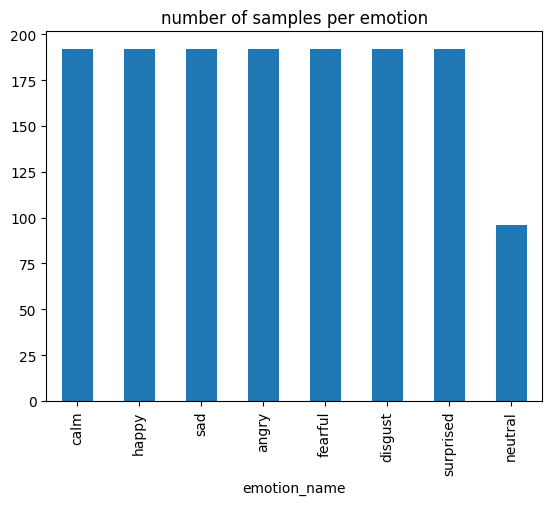

In [7]:
# Combining data sources for our use

df = pd.concat([df_RAVDESS[['file_path', 'emotion', 'emotion_name']]])

# Plot number of samples per emotion
df['emotion_name'].value_counts().plot(kind='bar')
plt.title("number of samples per emotion")
plt.show()

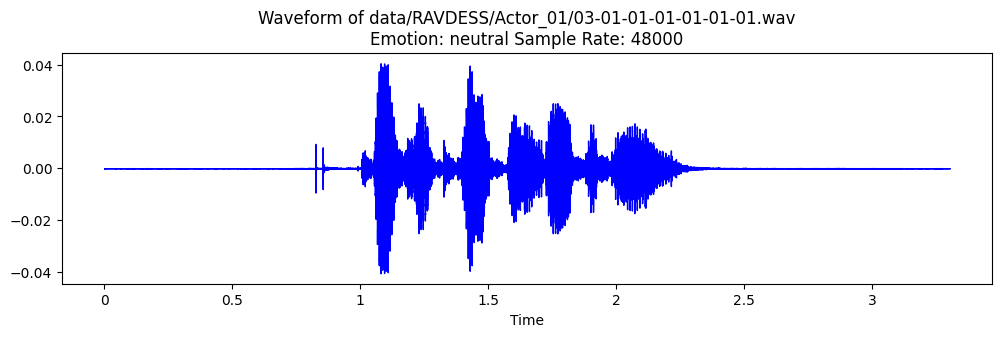

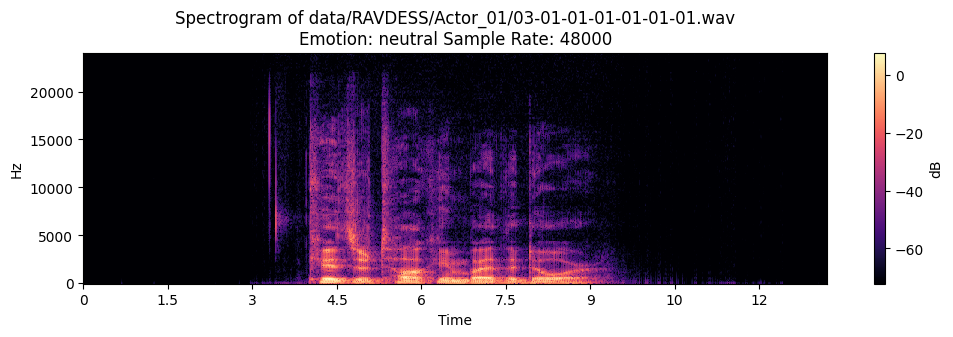

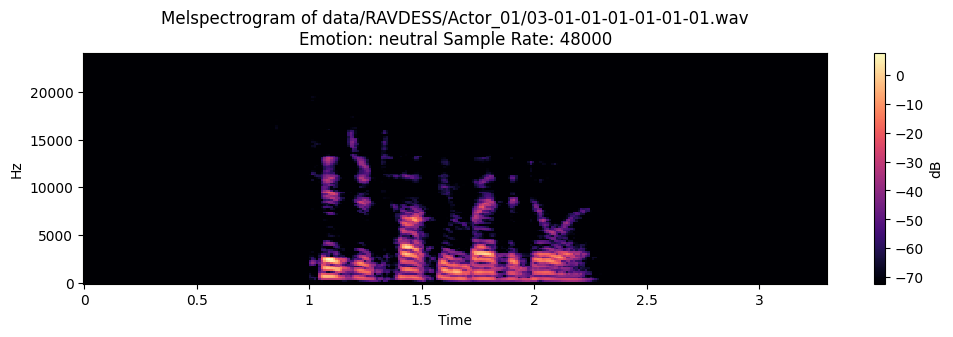

In [112]:
# Visualizing Data

def show_waveform(data, sr, path, emotion):
    plt.figure(figsize=(12, 3))
    plt.title(f"Waveform of {path}\nEmotion: {emotion} Sample Rate: {sr}")
    librosa.display.waveshow(data, sr=sample_rate, color='blue')
    plt.savefig("./plots/waveform.png")
    plt.show()

def show_spectrogram(data, sr, path, emotion):
    spectrogram_ampl = abs(librosa.stft(data, n_fft=512))
    spectrogram_dB = librosa.amplitude_to_db(spectrogram_ampl)
    plt.figure(figsize=(12,3))
    plt.title(f"Spectrogram of {path}\nEmotion: {emotion} Sample Rate: {sr}")
    librosa.display.specshow(spectrogram_dB, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(label="dB")
    plt.savefig("./plots/spectrogram.png")
    plt.show()

def show_melspectrogram(data, sr, path, emotion):
    melspec = librosa.feature.melspectrogram(y=data, sr=sr)
    melspec = librosa.amplitude_to_db(melspec)
    plt.figure(figsize=(12,3))
    plt.title(f"Melspectrogram of {path}\nEmotion: {emotion} Sample Rate: {sr}")
    librosa.display.specshow(melspec, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(label="dB")
    plt.savefig("./plots/melspectrogram.png")
    plt.show()
    
emotion = 'neutral'
path = np.array(df.file_path[df.emotion_name==emotion])[0]

# load audio data with librosa (running into issues importing with tf.audio on some files)
data, sample_rate = librosa.load(path, sr=48000)

# Plot waveforms and spectrogram of data
show_waveform(data, sample_rate, path, emotion)
show_spectrogram(data, sample_rate, path, emotion)
show_melspectrogram(data, sample_rate, path, emotion)

# Provide audio player to playback audio file
Audio(path)


In [9]:
# Load audio data from file, extract Mel-Frequencey Cepstral Coefficients (MFCCs), pair with label (emotion)
starttime_dataload = time.time()
DATA = []
max_length = 0
for row in df.iterrows():
    # print(row)
    file_path = row[1].iloc[0]
    emotion = row[1].iloc[1]
    data, sr = librosa.load(file_path, sr=48000)
    MFCCs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=128).T
    DATA.append((MFCCs, emotion))
    max_length = max(max_length, MFCCs.shape[0])
runtime_dataload = time.time()-starttime_dataload

In [10]:
# Padding Data to Uniform Length 
# https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size

def padding(array, xx, yy):
    h = array.shape[0]
    w = array.shape[1]
    a = (xx-h) // 2
    aa = xx - a - h
    b = (yy - w) //2
    bb = yy - b - w
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode = 'constant')
    
for i in range(len(DATA)):
    DATA[i] = padding(DATA[i][0], max_length, 128), DATA[i][1]    

Number of entries in Training Dataset: ((1080, 495, 128), (1080, 8))
Number of entries in Test Dataset: ((360, 495, 128), (360, 8))


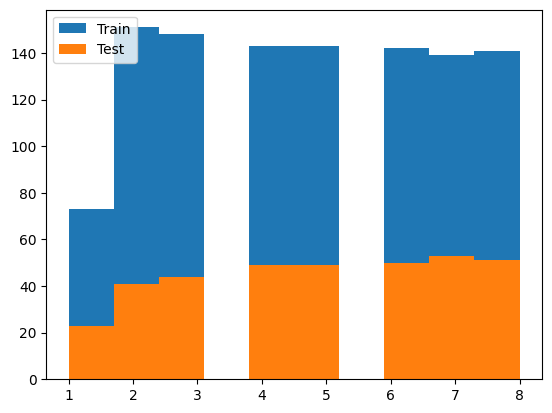

In [11]:
# Prepare data
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

features, labels = zip(*DATA)
features = np.asarray(features)
labels = np.array(labels).reshape((-1, 1))

# Split training/test data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=RANDOM_SEED)

# show data split
plt.hist(train_labels, label="Train")
plt.hist(test_labels, label="Test")
plt.legend()

# one-hot encode the emotion labels
ohc = OneHotEncoder()
train_labels = ohc.fit_transform(train_labels).toarray()
test_labels = ohc.transform(test_labels).toarray()

print(f'Number of entries in Training Dataset: {train_features.shape, train_labels.shape}')
print(f'Number of entries in Test Dataset: {test_features.shape, test_labels.shape}')

In [12]:
# Parameters for Models
batch_size = 200
num_epochs = 100
num_hidden_1 = 1000
num_hidden_2 = 250
val_split = 0.2
reduce_lr_on_plateau_factor = 0.1
reduce_lr_on_plateau_patience = 10
metrics = ['accuracy', 'Precision', 'Recall', 'F1Score']
loss = keras.losses.CategoricalCrossentropy()
optimizer = 'adam'
hidden_activation='relu'
output_activation='sigmoid'

In [13]:
# LSTM - Long Short Term Memory
model_LSTM = keras.models.Sequential()

model_LSTM.name = "LSTM"
model_LSTM.add(keras.Input(shape=(495, 128)))
model_LSTM.add(keras.layers.LSTM(num_hidden_1, return_sequences=False))
model_LSTM.add(keras.layers.Dense(num_hidden_2, activation=hidden_activation))
model_LSTM.add(keras.layers.Dense(8, activation=output_activation))
model_LSTM.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_LSTM.summary()

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1000)           │     4,516,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │       250,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,768,258 (18.19 MB)

 Trainable params: 4,768,258 (18.19 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# LSTM - Fitting
starttime_LSTM = time.time()
history_LSTM = model_LSTM.fit(train_features, train_labels, epochs=num_epochs,
                              batch_size=batch_size, validation_split=val_split, 
                              callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                                           factor=reduce_lr_on_plateau_factor, patience=reduce_lr_on_plateau_patience)])
runtime_LSTM = time.time()-starttime_LSTM
print(f"LSTM -- training time: {runtime_LSTM} seconds")

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 704ms/step - F1Score: 0.0700 - Precision: 0.1371 - Recall: 0.5965 - accuracy: 0.1524 - loss: 2.1524 - val_F1Score: 0.1181 - val_Precision: 0.1411 - val_Recall: 0.6944 - val_accuracy: 0.1806 - val_loss: 2.0440 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step - F1Score: 0.0962 - Precision: 0.1430 - Recall: 0.7028 - accuracy: 0.1777 - loss: 2.0596 - val_F1Score: 0.0730 - val_Precision: 0.1417 - val_Recall: 0.6991 - val_accuracy: 0.1250 - val_loss: 2.0460 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step - F1Score: 0.1141 - Precision: 0.1484 - Recall: 0.7424 - accuracy: 0.1962 - loss: 2.0443 - val_F1Score: 0.0985 - val_Precision: 0.1604 - val_Recall: 0.8056 - val_accuracy: 0.1481 - val_loss: 2.0246 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step - F1Score: 0.1294 - Precision: 0.1548 - Recall: 0.7653 - accuracy: 0.2048 - loss: 1.9950 - val_F1Score: 0.1011 - val_Precision: 0.

In [15]:
# GRU - Gated Recurrent Units
model_GRU = keras.models.Sequential()

model_GRU.name = "GRU"
model_GRU.add(keras.Input(shape=(495, 128)))
model_GRU.add(keras.layers.GRU(num_hidden_1, return_sequences=False))
model_GRU.add(keras.layers.Dense(num_hidden_2, activation=hidden_activation))
model_GRU.add(keras.layers.Dense(8, activation=output_activation))
model_GRU.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_GRU.summary()

Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1000)           │     3,390,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 250)            │       250,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,642,258 (13.89 MB)

 Trainable params: 3,642,258 (13.89 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# GRU - Fitting
starttime_GRU = time.time()
history_GRU = model_GRU.fit(train_features, train_labels, epochs=num_epochs,
                              batch_size=batch_size, validation_split=val_split, 
                              callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                                           factor=reduce_lr_on_plateau_factor, patience=reduce_lr_on_plateau_patience)])
runtime_GRU = time.time()-starttime_GRU
print(f"GRU -- training time: {runtime_GRU} seconds")

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - F1Score: 0.1777 - Precision: 0.1330 - Recall: 0.3842 - accuracy: 0.0817 - loss: 2.0767 - val_F1Score: 0.0192 - val_Precision: 0.1281 - val_Recall: 0.7685 - val_accuracy: 0.0833 - val_loss: 2.0627 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - F1Score: 0.0401 - Precision: 0.1305 - Recall: 0.8159 - accuracy: 0.1260 - loss: 2.0634 - val_F1Score: 0.0192 - val_Precision: 0.1281 - val_Recall: 0.7685 - val_accuracy: 0.0833 - val_loss: 2.0535 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - F1Score: 0.0462 - Precision: 0.1329 - Recall: 0.7966 - accuracy: 0.1313 - loss: 2.0597 - val_F1Score: 0.0525 - val_Precision: 0.1434 - val_Recall: 0.8056 - val_accuracy: 0.1019 - val_loss: 2.1267 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - F1Score: 0.0487 - Precision: 0.1415 - Recall: 0.7634 - accuracy: 0.1309 - loss: 2.1143 - val_F1Score: 0.0420 - val_Precision: 0.

In [17]:
# SRNN - Simple Recurrent Neural Network
model_SRNN = keras.models.Sequential()

model_SRNN.name = "SimpleRNN"
model_SRNN.add(keras.Input(shape=(495, 128)))
model_SRNN.add(keras.layers.SimpleRNN(num_hidden_1, return_sequences=False))
model_SRNN.add(keras.layers.Dense(num_hidden_2, activation=hidden_activation))
model_SRNN.add(keras.layers.Dense(8, activation=output_activation))
model_SRNN.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
model_SRNN.summary()

Model: "SimpleRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1000)           │     1,129,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 250)            │       250,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         2,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,381,258 (5.27 MB)

 Trainable params: 1,381,258 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# SRNN - Fitting
starttime_SRNN = time.time()
history_SRNN = model_SRNN.fit(train_features, train_labels, epochs=num_epochs,
                              batch_size=batch_size, validation_split=val_split, 
                              callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                                           factor=reduce_lr_on_plateau_factor, patience=reduce_lr_on_plateau_patience)])
runtime_SRNN = time.time()-starttime_SRNN
print(f"SRNN -- training time: {runtime_SRNN} seconds")

Epoch 1/100


I0000 00:00:1713466976.706094  426136 service.cc:145] XLA service 0x7efd667c7580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713466976.706164  426136 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
I0000 00:00:1713466978.401237  426136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 956ms/step - F1Score: 0.0907 - Precision: 0.1227 - Recall: 0.5468 - accuracy: 0.1087 - loss: 2.1560 - val_F1Score: 0.0677 - val_Precision: 0.1333 - val_Recall: 0.5787 - val_accuracy: 0.0833 - val_loss: 2.5838 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - F1Score: 0.1012 - Precision: 0.1217 - Recall: 0.5473 - accuracy: 0.1198 - loss: 2.4625 - val_F1Score: 0.0676 - val_Precision: 0.1136 - val_Recall: 0.5324 - val_accuracy: 0.1065 - val_loss: 2.6489 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - F1Score: 0.1047 - Precision: 0.1216 - Recall: 0.6128 - accuracy: 0.1226 - loss: 2.5443 - val_F1Score: 0.0617 - val_Precision: 0.1153 - val_Recall: 0.5278 - val_accuracy: 0.1389 - val_loss: 2.4855 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - F1Score: 0.0851 - Precision: 0.1310 - Recall: 0.6073 - accuracy: 0.1187 - loss: 2.3462 - val_F1Score: 0.0752 - val_Precision: 0.1345 - val_R

In [19]:
# CNN
model_CNN = keras.models.Sequential()

model_CNN.name = "CNN"
model_CNN.add(keras.Input(shape=(495, 128)))
model_CNN.add(keras.layers.Conv1D(num_hidden_1, data_format="channels_last", kernel_size=1))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(num_hidden_2, activation=hidden_activation))
model_CNN.add(keras.layers.Dense(8, activation=output_activation))
model_CNN.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
model_CNN.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 495, 1000)      │       129,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 1000)           │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 250)            │       250,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         2,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 381,258 (1.45 MB)

 Trainable params: 381,258 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# CNN - Fitting
starttime_CNN = time.time()
history_CNN = model_CNN.fit(train_features, train_labels, epochs=num_epochs,
                              batch_size=batch_size, validation_split=val_split, 
                              callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                                           factor=reduce_lr_on_plateau_factor, patience=reduce_lr_on_plateau_patience)])
runtime_CNN = time.time()-starttime_CNN
print(f"CNN -- training time: {runtime_CNN} seconds")

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 621ms/step - F1Score: 0.1629 - Precision: 0.1204 - Recall: 0.6337 - accuracy: 0.0821 - loss: 51.3814 - val_F1Score: 0.1330 - val_Precision: 0.1204 - val_Recall: 0.6019 - val_accuracy: 0.0694 - val_loss: 65.4305 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - F1Score: 0.1445 - Precision: 0.1220 - Recall: 0.6274 - accuracy: 0.0681 - loss: 73.9246 - val_F1Score: 0.1335 - val_Precision: 0.1222 - val_Recall: 0.7315 - val_accuracy: 0.0694 - val_loss: 36.7235 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - F1Score: 0.1343 - Precision: 0.1220 - Recall: 0.6553 - accuracy: 0.0634 - loss: 44.0511 - val_F1Score: 0.1089 - val_Precision: 0.1148 - val_Recall: 0.4676 - val_accuracy: 0.0741 - val_loss: 30.1045 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - F1Score: 0.1650 - Precision: 0.1380 - Recall: 0.6454 - accuracy: 0.1559 - loss: 21.0704 - val_F1Score: 0.1429 - val_Precision

In [21]:
# Multi-Layer Perceptron
model_MLP = keras.models.Sequential()

model_MLP.name = "MLP"
model_MLP.add(keras.Input(shape=(495, 128)))
model_MLP.add(keras.layers.Dense(num_hidden_1, activation='relu'))
model_MLP.add(keras.layers.GlobalMaxPooling1D())
model_MLP.add(keras.layers.Dense(num_hidden_2, activation=hidden_activation))
model_MLP.add(keras.layers.Dense(8, activation=output_activation))
model_MLP.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
model_MLP.summary()

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 495, 1000)      │       129,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 1000)           │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 250)            │       250,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │         2,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 381,258 (1.45 MB)

 Trainable params: 381,258 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# MLP - Fitting
starttime_MLP = time.time()
history_MLP = model_MLP.fit(train_features, train_labels, epochs=num_epochs,
                              batch_size=batch_size, validation_split=val_split, 
                              callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                                           factor=reduce_lr_on_plateau_factor, patience=reduce_lr_on_plateau_patience)])
runtime_MLP = time.time()-starttime_CNN
print(f"MLP -- training time: {runtime_CNN} seconds")

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step - F1Score: 0.0896 - Precision: 0.1313 - Recall: 0.2112 - accuracy: 0.1479 - loss: 64.0527 - val_F1Score: 0.0409 - val_Precision: 0.1626 - val_Recall: 0.4583 - val_accuracy: 0.1620 - val_loss: 80.1129 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - F1Score: 0.0729 - Precision: 0.1375 - Recall: 0.4089 - accuracy: 0.1231 - loss: 72.3407 - val_F1Score: 0.1187 - val_Precision: 0.1667 - val_Recall: 0.3611 - val_accuracy: 0.2037 - val_loss: 36.9393 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - F1Score: 0.1403 - Precision: 0.2135 - Recall: 0.2326 - accuracy: 0.2064 - loss: 31.9908 - val_F1Score: 0.1044 - val_Precision: 1.0000 - val_Recall: 0.0093 - val_accuracy: 0.1713 - val_loss: 18.3294 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - F1Score: 0.1416 - Precision: 0.4977 - Recall: 0.0080 - accuracy: 0.1792 - loss: 14.4082 - val_F1Score: 0.0698 - val_Precision

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - F1Score: 0.5464 - Precision: 0.2506 - Recall: 0.8817 - accuracy: 0.5620 - loss: 1.8639


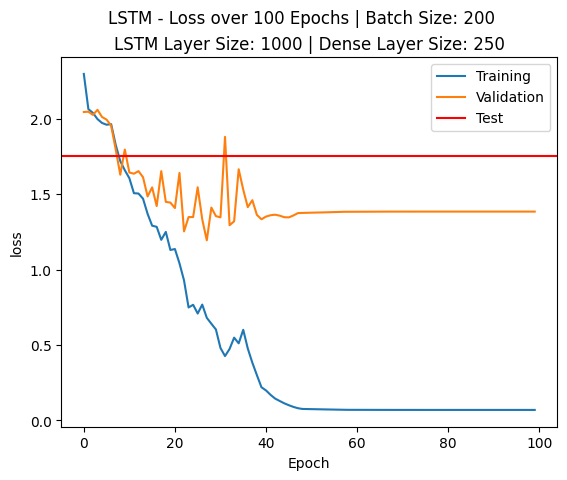

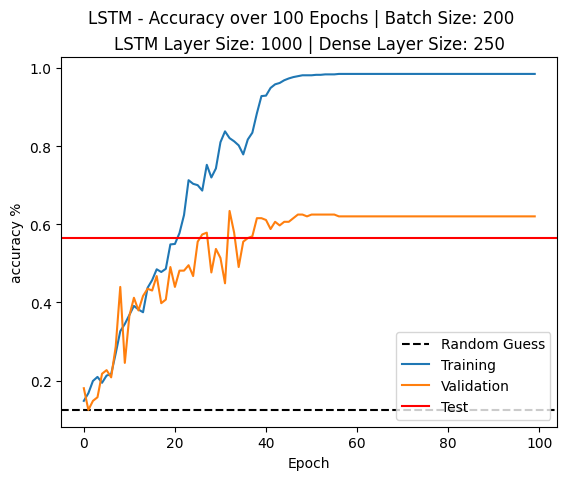

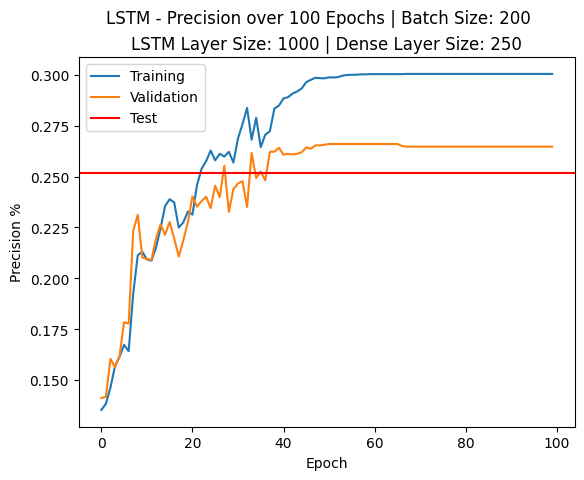

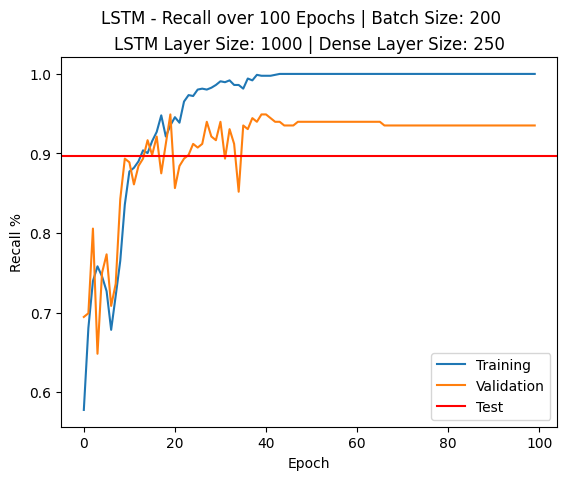

In [23]:
# Results -- LSTM
layer_type = 'LSTM'
results_LSTM = model_LSTM.evaluate(test_features, test_labels, return_dict=True)

# Loss
plt.plot(history_LSTM.history['loss'], label='Training')
plt.plot(history_LSTM.history['val_loss'], label='Validation')
plt.axhline(results_LSTM['loss'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Loss over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Accuracy
plt.axhline(1/8, ls='dashed', label='Random Guess', color='black')
plt.plot(history_LSTM.history['accuracy'], label='Training')
plt.plot(history_LSTM.history['val_accuracy'], label='Validation')
plt.axhline(results_LSTM['accuracy'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Accuracy over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("accuracy %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Precision
plt.plot(history_LSTM.history['Precision'], label='Training')
plt.plot(history_LSTM.history['val_Precision'], label='Validation')
plt.axhline(results_LSTM['Precision'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Precision over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Precision %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Recall
plt.plot(history_LSTM.history['Recall'], label='Training')
plt.plot(history_LSTM.history['val_Recall'], label='Validation')
plt.axhline(results_LSTM['Recall'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Recall over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Recall %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# F1Score
# plt.plot(history_LSTM.history['F1Score'], label='Training')
# plt.plot(history_LSTM.history['val_F1Score'], label='Validation')
# plt.suptitle(f"{layer_type} - F1Score over {num_epochs} Epochs | Batch Size: {batch_size}")
# plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
# plt.ylabel("F1Score %")
# plt.xlabel("Epoch")
# plt.xlim(0, 100)
# plt.ylim(0, 1.0)
# plt.legend()
# plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - F1Score: 0.3331 - Precision: 0.2534 - Recall: 0.7931 - accuracy: 0.3724 - loss: 2.3698


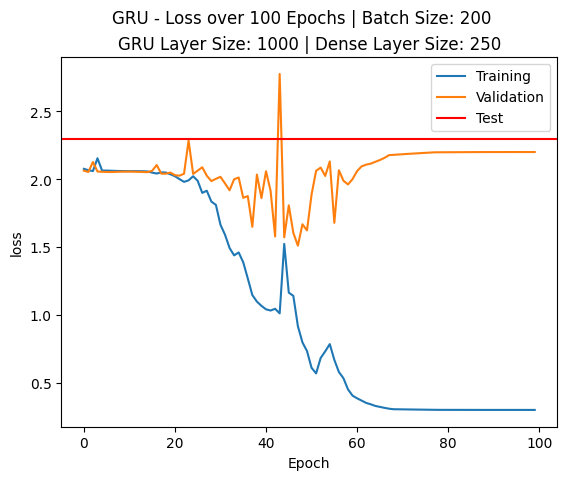

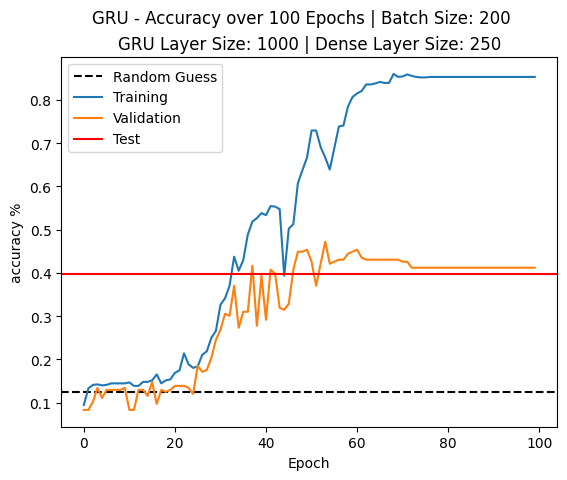

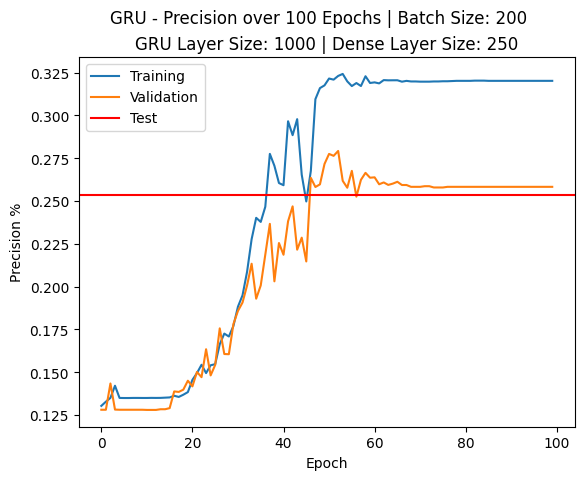

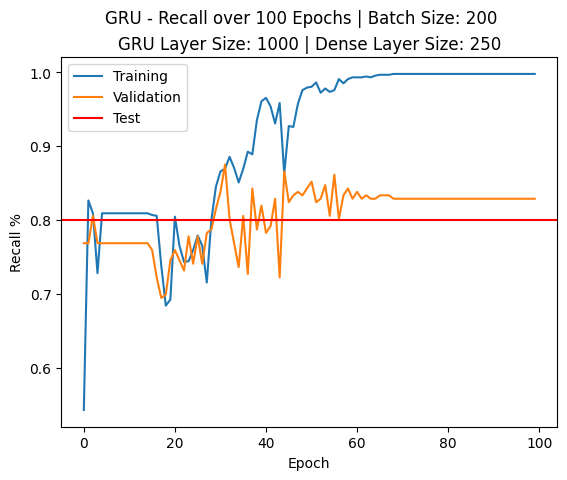

In [24]:
# Results -- GRU
layer_type = 'GRU'
results_GRU = model_GRU.evaluate(test_features, test_labels, return_dict=True)

# Loss
plt.plot(history_GRU.history['loss'], label='Training')
plt.plot(history_GRU.history['val_loss'], label='Validation')
plt.axhline(results_GRU['loss'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Loss over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Accuracy
plt.axhline(1/8, ls='dashed', label='Random Guess', color='black')
plt.plot(history_GRU.history['accuracy'], label='Training')
plt.plot(history_GRU.history['val_accuracy'], label='Validation')
plt.axhline(results_GRU['accuracy'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Accuracy over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("accuracy %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Precision
plt.plot(history_GRU.history['Precision'], label='Training')
plt.plot(history_GRU.history['val_Precision'], label='Validation')
plt.axhline(results_GRU['Precision'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Precision over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Precision %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Recall
plt.plot(history_GRU.history['Recall'], label='Training')
plt.plot(history_GRU.history['val_Recall'], label='Validation')
plt.axhline(results_GRU['Recall'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Recall over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Recall %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# F1Score
# plt.plot(history_GRU.history['F1Score'], label='Training')
# plt.plot(history_GRU.history['val_F1Score'], label='Validation')
# plt.suptitle(f"{layer_type} - F1Score over {num_epochs} Epochs | Batch Size: {batch_size}")
# plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
# plt.ylabel("F1Score %")
# plt.xlabel("Epoch")
# plt.xlim(0, 100)
# plt.ylim(0, 1.0)
# plt.legend()
# plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - F1Score: 0.0816 - Precision: 0.1265 - Recall: 0.8855 - accuracy: 0.1498 - loss: 2.0655


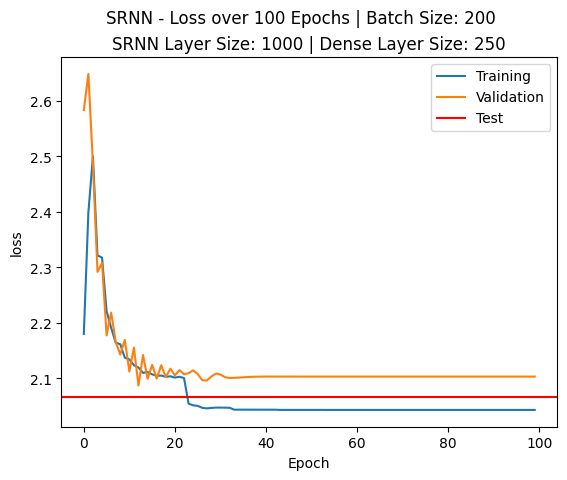

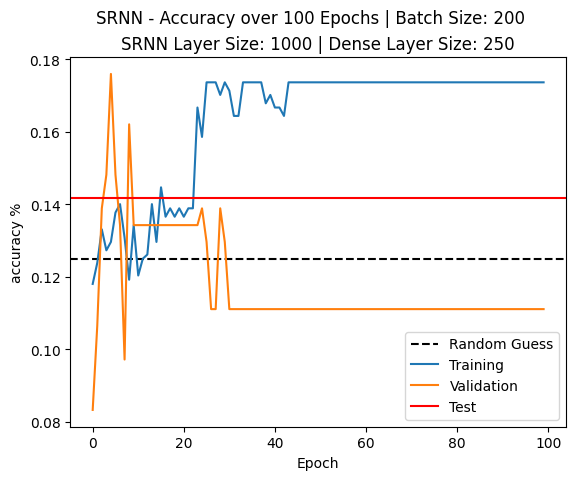

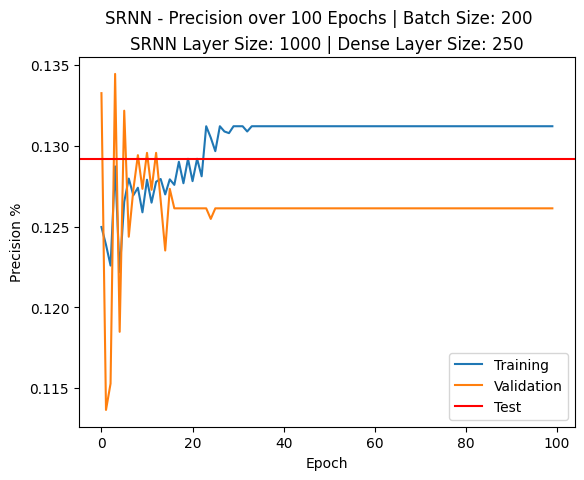

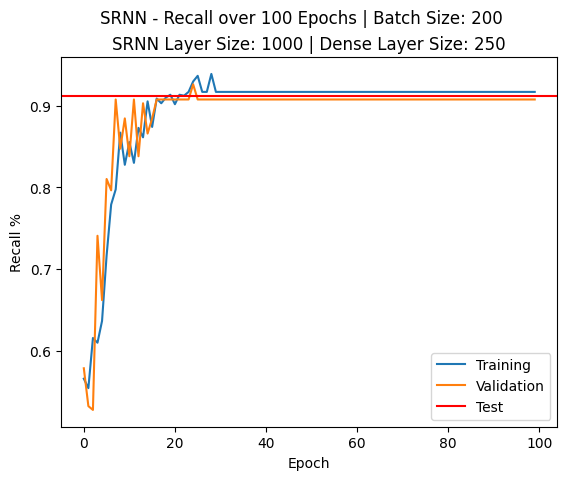

In [25]:
# Results -- Simple RNN
layer_type = 'SRNN'
results_SRNN = model_SRNN.evaluate(test_features, test_labels, return_dict=True)

# Loss
plt.plot(history_SRNN.history['loss'], label='Training')
plt.plot(history_SRNN.history['val_loss'], label='Validation')
plt.axhline(results_SRNN['loss'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Loss over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Accuracy
plt.axhline(1/8, ls='dashed', label='Random Guess', color='black')
plt.plot(history_SRNN.history['accuracy'], label='Training')
plt.plot(history_SRNN.history['val_accuracy'], label='Validation')
plt.axhline(results_SRNN['accuracy'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Accuracy over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("accuracy %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Precision
plt.plot(history_SRNN.history['Precision'], label='Training')
plt.plot(history_SRNN.history['val_Precision'], label='Validation')
plt.axhline(results_SRNN['Precision'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Precision over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Precision %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Recall
plt.plot(history_SRNN.history['Recall'], label='Training')
plt.plot(history_SRNN.history['val_Recall'], label='Validation')
plt.axhline(results_SRNN['Recall'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Recall over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Recall %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# F1Score
# plt.plot(history_SRNN.history['F1Score'], label='Training')
# plt.plot(history_SRNN.history['val_F1Score'], label='Validation')
# plt.suptitle(f"{layer_type} - F1Score over {num_epochs} Epochs | Batch Size: {batch_size}")
# plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
# plt.ylabel("F1Score %")
# plt.xlabel("Epoch")
# plt.xlim(0, 100)
# plt.ylim(0, 1.0)
# plt.legend()
# plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - F1Score: 0.4869 - Precision: 0.3156 - Recall: 0.6824 - accuracy: 0.4983 - loss: 1.5498


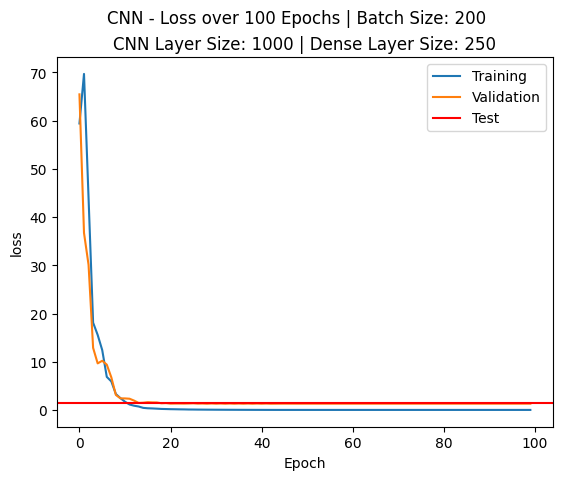

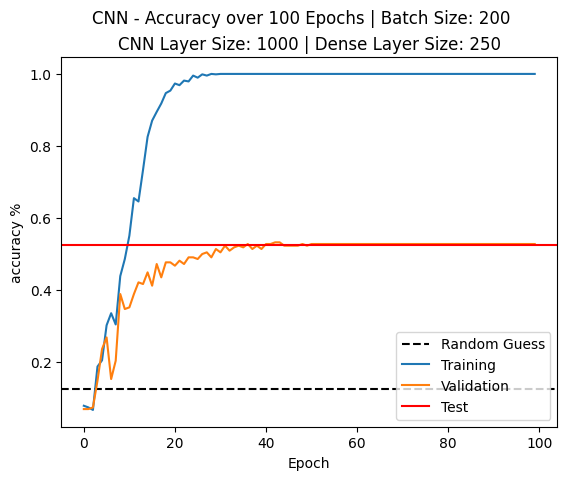

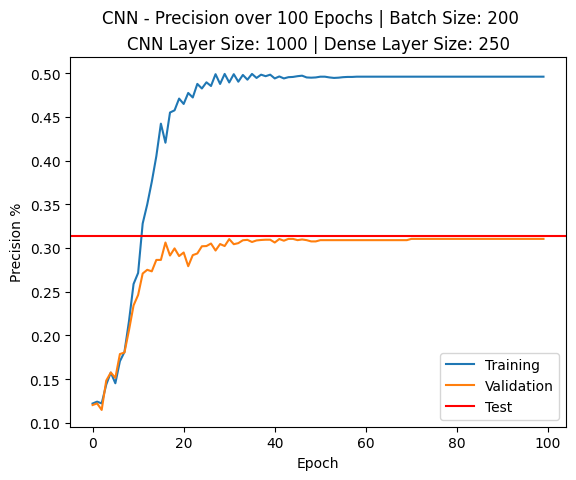

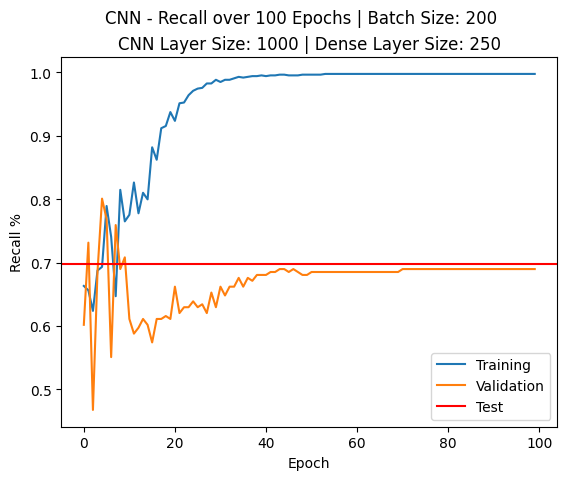

In [26]:
# Results -- CNN
layer_type = 'CNN'
results_CNN = model_CNN.evaluate(test_features, test_labels, return_dict=True)

# Loss
plt.plot(history_CNN.history['loss'], label='Training')
plt.plot(history_CNN.history['val_loss'], label='Validation')
plt.axhline(results_CNN['loss'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Loss over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Accuracy
plt.axhline(1/8, ls='dashed', label='Random Guess', color='black')
plt.plot(history_CNN.history['accuracy'], label='Training')
plt.plot(history_CNN.history['val_accuracy'], label='Validation')
plt.axhline(results_CNN['accuracy'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Accuracy over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("accuracy %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Precision
plt.plot(history_CNN.history['Precision'], label='Training')
plt.plot(history_CNN.history['val_Precision'], label='Validation')
plt.axhline(results_CNN['Precision'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Precision over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Precision %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Recall
plt.plot(history_CNN.history['Recall'], label='Training')
plt.plot(history_CNN.history['val_Recall'], label='Validation')
plt.axhline(results_CNN['Recall'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Recall over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Recall %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# F1Score
# plt.plot(history_CNN.history['F1Score'], label='Training')
# plt.plot(history_CNN.history['val_F1Score'], label='Validation')
# plt.suptitle(f"{layer_type} - F1Score over {num_epochs} Epochs | Batch Size: {batch_size}")
# plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
# plt.ylabel("F1Score %")
# plt.xlabel("Epoch")
# plt.xlim(0, 100)
# plt.ylim(0, 1.0)
# plt.legend()
# plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - F1Score: 0.4453 - Precision: 0.9231 - Recall: 0.0163 - accuracy: 0.4709 - loss: 1.4715      


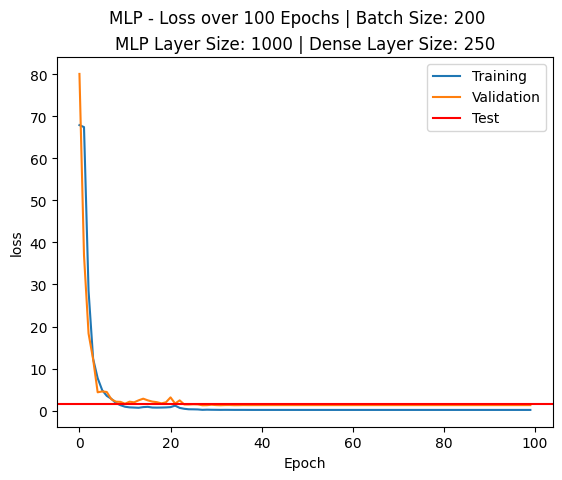

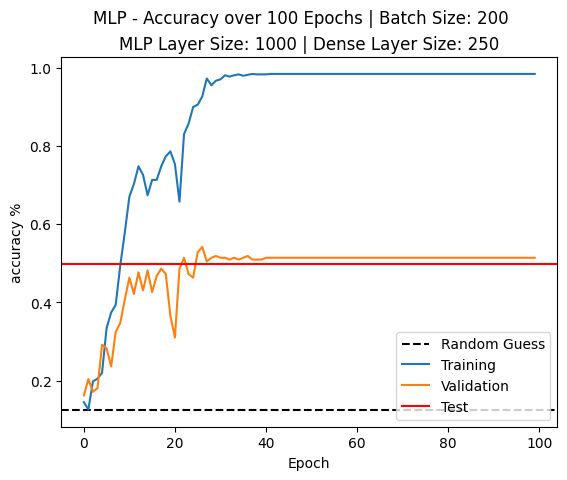

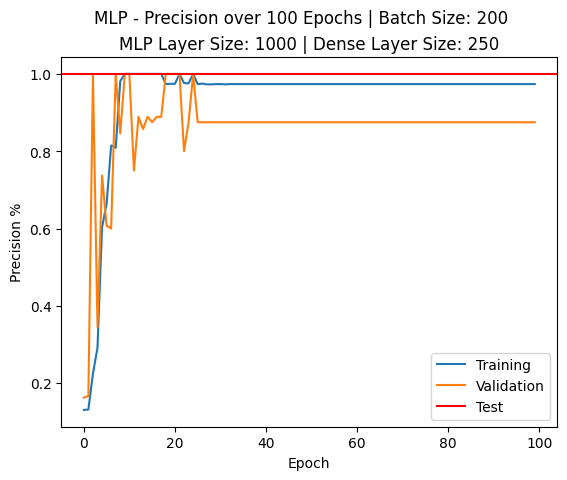

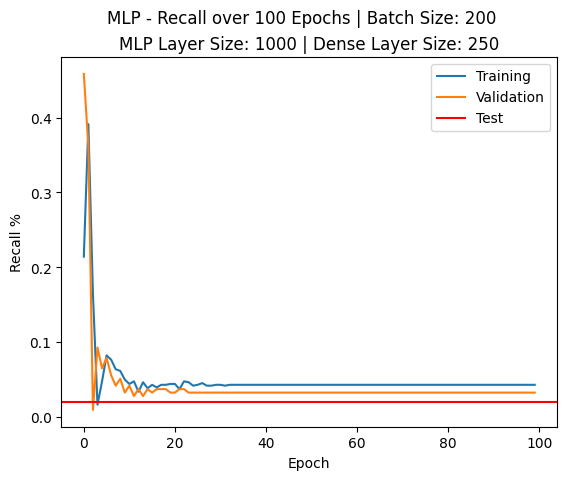

In [27]:
# Results -- MLP
layer_type = 'MLP'
results_MLP = model_MLP.evaluate(test_features, test_labels, return_dict=True)

# Loss
plt.plot(history_MLP.history['loss'], label='Training')
plt.plot(history_MLP.history['val_loss'], label='Validation')
plt.axhline(results_MLP['loss'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Loss over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Accuracy
plt.axhline(1/8, ls='dashed', label='Random Guess', color='black')
plt.plot(history_MLP.history['accuracy'], label='Training')
plt.plot(history_MLP.history['val_accuracy'], label='Validation')
plt.axhline(results_MLP['accuracy'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Accuracy over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("accuracy %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Precision
plt.plot(history_MLP.history['Precision'], label='Training')
plt.plot(history_MLP.history['val_Precision'], label='Validation')
plt.axhline(results_MLP['Precision'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Precision over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Precision %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Recall
plt.plot(history_MLP.history['Recall'], label='Training')
plt.plot(history_MLP.history['val_Recall'], label='Validation')
plt.axhline(results_MLP['Recall'], label='Test', color='red')
plt.suptitle(f"{layer_type} - Recall over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Recall %")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# F1Score
# plt.plot(history_MLP.history['F1Score'], label='Training')
# plt.plot(history_MLP.history['val_F1Score'], label='Validation')
# plt.suptitle(f"{layer_type} - F1Score over {num_epochs} Epochs | Batch Size: {batch_size}")
# plt.title(f"{layer_type} Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
# plt.ylabel("F1Score %")
# plt.xlabel("Epoch")
# plt.xlim(0, 100)
# plt.ylim(0, 1.0)
# plt.legend()
# plt.show()

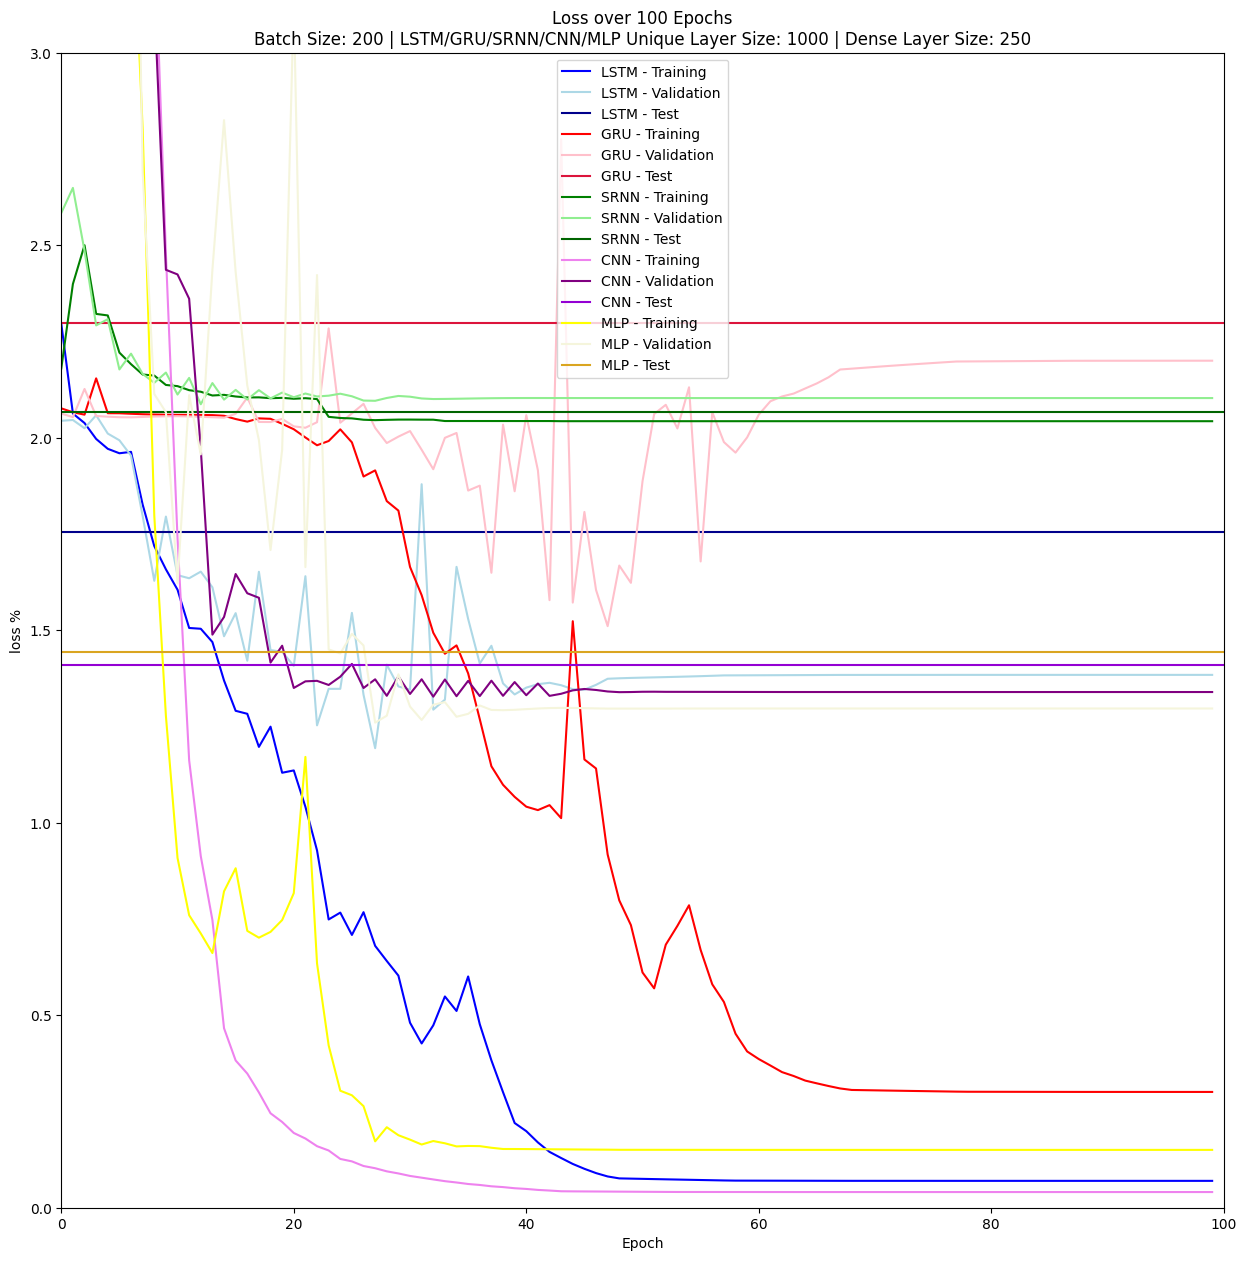

LSTM Test Loss: 1.7548643350601196
GRU Test Loss: 2.2976386547088623
SimpleRNN Test Loss: 2.066998243331909
CNN Test Loss: 1.4084171056747437
MLP Test Loss: 1.4428977966308594


In [44]:
# Comparison -- Loss
plt.figure(figsize=(15, 15))

plt.plot(history_LSTM.history['loss'], label='LSTM - Training', color='blue')
plt.plot(history_LSTM.history['val_loss'], label='LSTM - Validation', color='lightblue')
plt.axhline(results_LSTM['loss'], label='LSTM - Test', color='darkblue')

plt.plot(history_GRU.history['loss'], label='GRU - Training', color='red')
plt.plot(history_GRU.history['val_loss'], label='GRU - Validation', color='pink')
plt.axhline(results_GRU['loss'], label='GRU - Test', color='crimson')

plt.plot(history_SRNN.history['loss'], label='SRNN - Training', color='green')
plt.plot(history_SRNN.history['val_loss'], label='SRNN - Validation', color='lightgreen')
plt.axhline(results_SRNN['loss'], label='SRNN - Test', color='darkgreen')

plt.plot(history_CNN.history['loss'], label='CNN - Training', color='violet')
plt.plot(history_CNN.history['val_loss'], label='CNN - Validation', color='purple')
plt.axhline(results_CNN['loss'], label='CNN - Test', color='darkviolet')

plt.plot(history_MLP.history['loss'], label='MLP - Training', color='yellow')
plt.plot(history_MLP.history['val_loss'], label='MLP - Validation', color='beige')
plt.axhline(results_MLP['loss'], label='MLP - Test', color='goldenrod')

plt.title(f"Loss over {num_epochs} Epochs\nBatch Size: {batch_size} | LSTM/GRU/SRNN/CNN/MLP Unique Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("loss %")
plt.xlabel("Epoch")
plt.xlim(0, 100)
plt.ylim(0, 3.0)
plt.legend()
plt.show()

print(f"LSTM Test Loss: {results_LSTM['loss']}")
print(f"GRU Test Loss: {results_GRU['loss']}")
print(f"SimpleRNN Test Loss: {results_SRNN['loss']}")
print(f"CNN Test Loss: {results_CNN['loss']}")
print(f"MLP Test Loss: {results_MLP['loss']}")

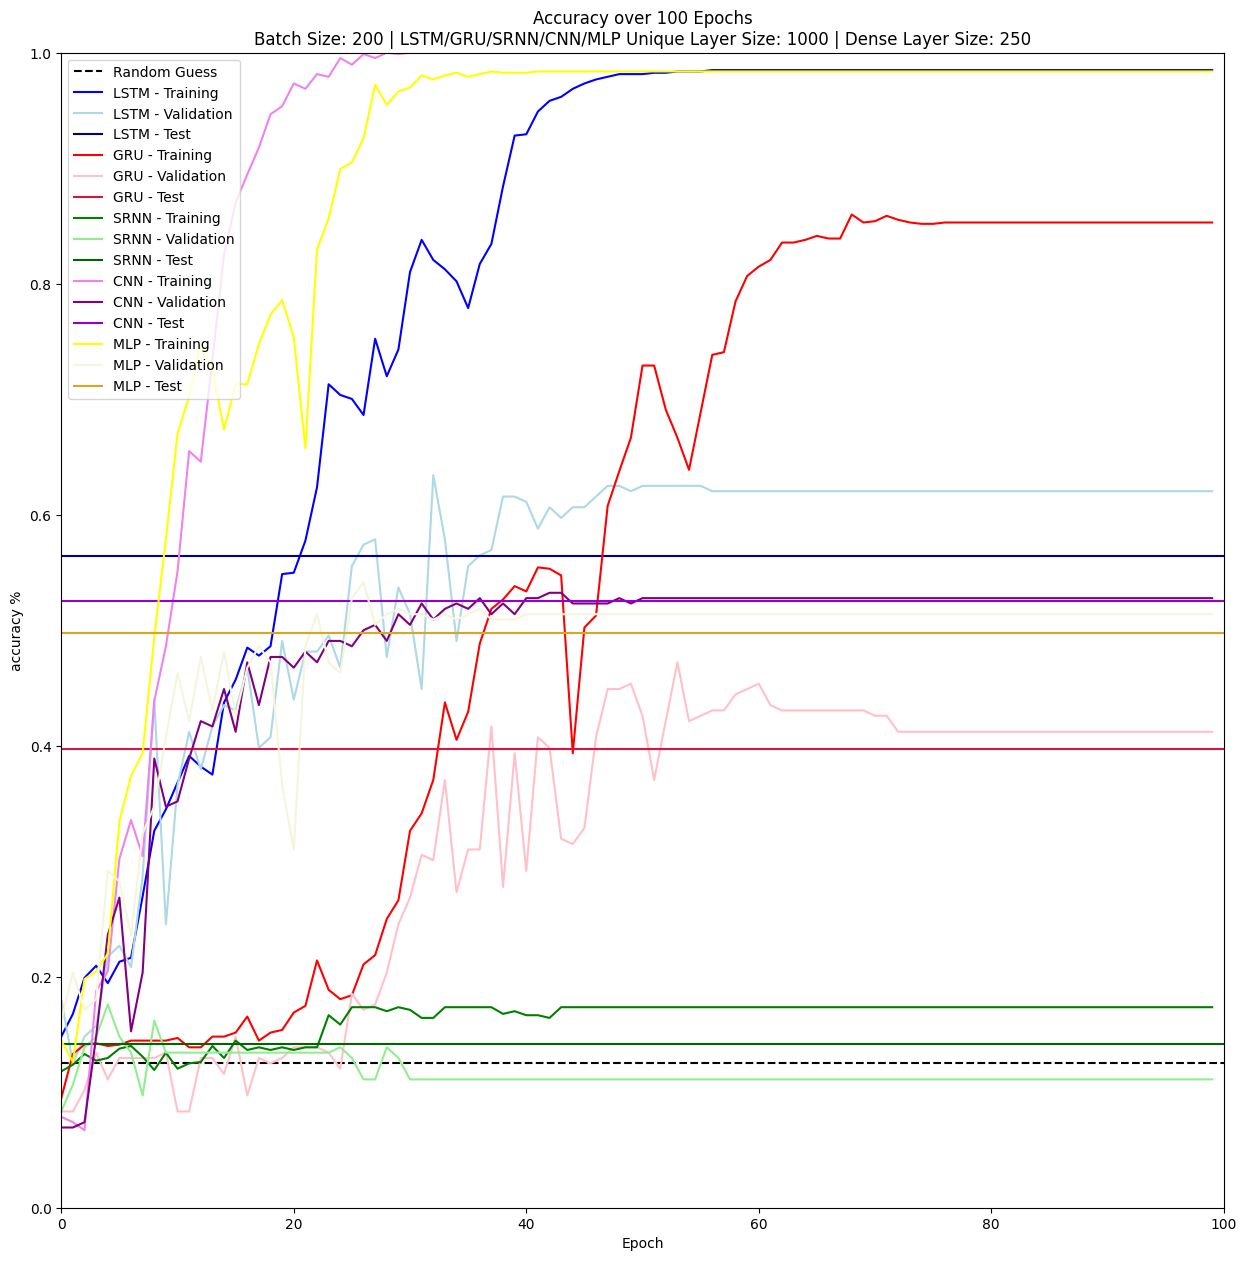

LSTM Test Accuracy: 0.5638889074325562
GRU Test Accuracy: 0.39722222089767456
SimpleRNN Test Accuracy: 0.14166666567325592
CNN Test Accuracy: 0.5249999761581421
MLP Test Accuracy: 0.4972222149372101


In [43]:
# Comparison -- Accuracy
plt.figure(figsize=(15, 15))
plt.axhline(1/8, ls='dashed', label='Random Guess', color='black')

plt.plot(history_LSTM.history['accuracy'], label='LSTM - Training', color='blue')
plt.plot(history_LSTM.history['val_accuracy'], label='LSTM - Validation', color='lightblue')
plt.axhline(results_LSTM['accuracy'], label='LSTM - Test', color='darkblue')

plt.plot(history_GRU.history['accuracy'], label='GRU - Training', color='red')
plt.plot(history_GRU.history['val_accuracy'], label='GRU - Validation', color='pink')
plt.axhline(results_GRU['accuracy'], label='GRU - Test', color='crimson')

plt.plot(history_SRNN.history['accuracy'], label='SRNN - Training', color='green')
plt.plot(history_SRNN.history['val_accuracy'], label='SRNN - Validation', color='lightgreen')
plt.axhline(results_SRNN['accuracy'], label='SRNN - Test', color='darkgreen')

plt.plot(history_CNN.history['accuracy'], label='CNN - Training', color='violet')
plt.plot(history_CNN.history['val_accuracy'], label='CNN - Validation', color='purple')
plt.axhline(results_CNN['accuracy'], label='CNN - Test', color='darkviolet')

plt.plot(history_MLP.history['accuracy'], label='MLP - Training', color='yellow')
plt.plot(history_MLP.history['val_accuracy'], label='MLP - Validation', color='beige')
plt.axhline(results_MLP['accuracy'], label='MLP - Test', color='goldenrod')

plt.title(f"Accuracy over {num_epochs} Epochs\nBatch Size: {batch_size} | LSTM/GRU/SRNN/CNN/MLP Unique Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("accuracy %")
plt.xlabel("Epoch")
plt.xlim(0, 100)
plt.ylim(0, 1.0)
plt.legend()
plt.show()

print(f"LSTM Test Accuracy: {results_LSTM['accuracy']}")
print(f"GRU Test Accuracy: {results_GRU['accuracy']}")
print(f"SimpleRNN Test Accuracy: {results_SRNN['accuracy']}")
print(f"CNN Test Accuracy: {results_CNN['accuracy']}")
print(f"MLP Test Accuracy: {results_MLP['accuracy']}")

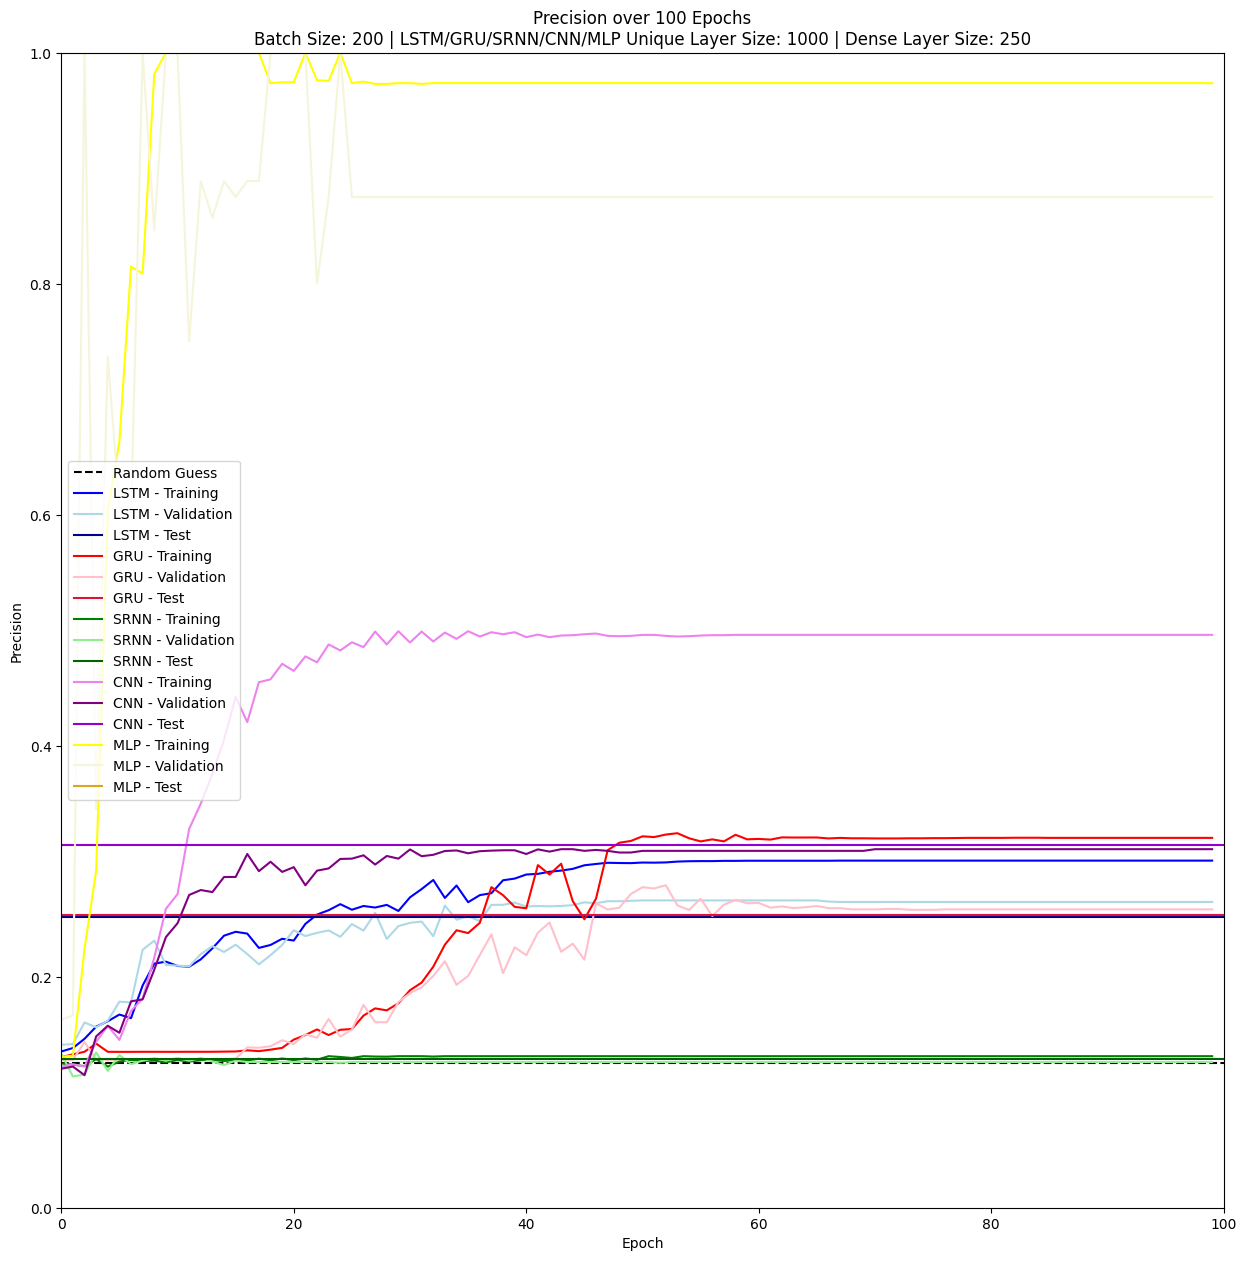

LSTM Test Precision: 0.25175368785858154
GRU Test Precision: 0.2535211145877838
SimpleRNN Test Precision: 0.12918472290039062
CNN Test Precision: 0.3137499988079071
MLP Test Precision: 1.0


In [45]:
# Comparison -- Precision
plt.figure(figsize=(15, 15))
plt.axhline(1/8, ls='dashed', label='Random Guess', color='black')

plt.plot(history_LSTM.history['Precision'], label='LSTM - Training', color='blue')
plt.plot(history_LSTM.history['val_Precision'], label='LSTM - Validation', color='lightblue')
plt.axhline(results_LSTM['Precision'], label='LSTM - Test', color='darkblue')

plt.plot(history_GRU.history['Precision'], label='GRU - Training', color='red')
plt.plot(history_GRU.history['val_Precision'], label='GRU - Validation', color='pink')
plt.axhline(results_GRU['Precision'], label='GRU - Test', color='crimson')

plt.plot(history_SRNN.history['Precision'], label='SRNN - Training', color='green')
plt.plot(history_SRNN.history['val_Precision'], label='SRNN - Validation', color='lightgreen')
plt.axhline(results_SRNN['Precision'], label='SRNN - Test', color='darkgreen')

plt.plot(history_CNN.history['Precision'], label='CNN - Training', color='violet')
plt.plot(history_CNN.history['val_Precision'], label='CNN - Validation', color='purple')
plt.axhline(results_CNN['Precision'], label='CNN - Test', color='darkviolet')

plt.plot(history_MLP.history['Precision'], label='MLP - Training', color='yellow')
plt.plot(history_MLP.history['val_Precision'], label='MLP - Validation', color='beige')
plt.axhline(results_MLP['Precision'], label='MLP - Test', color='goldenrod')

plt.title(f"Precision over {num_epochs} Epochs\nBatch Size: {batch_size} | LSTM/GRU/SRNN/CNN/MLP Unique Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Precision")
plt.xlabel("Epoch")
plt.xlim(0, 100)
plt.ylim(0, 1.0)
plt.legend()
plt.show()

print(f"LSTM Test Precision: {results_LSTM['Precision']}")
print(f"GRU Test Precision: {results_GRU['Precision']}")
print(f"SimpleRNN Test Precision: {results_SRNN['Precision']}")
print(f"CNN Test Precision: {results_CNN['Precision']}")
print(f"MLP Test Precision: {results_MLP['Precision']}")

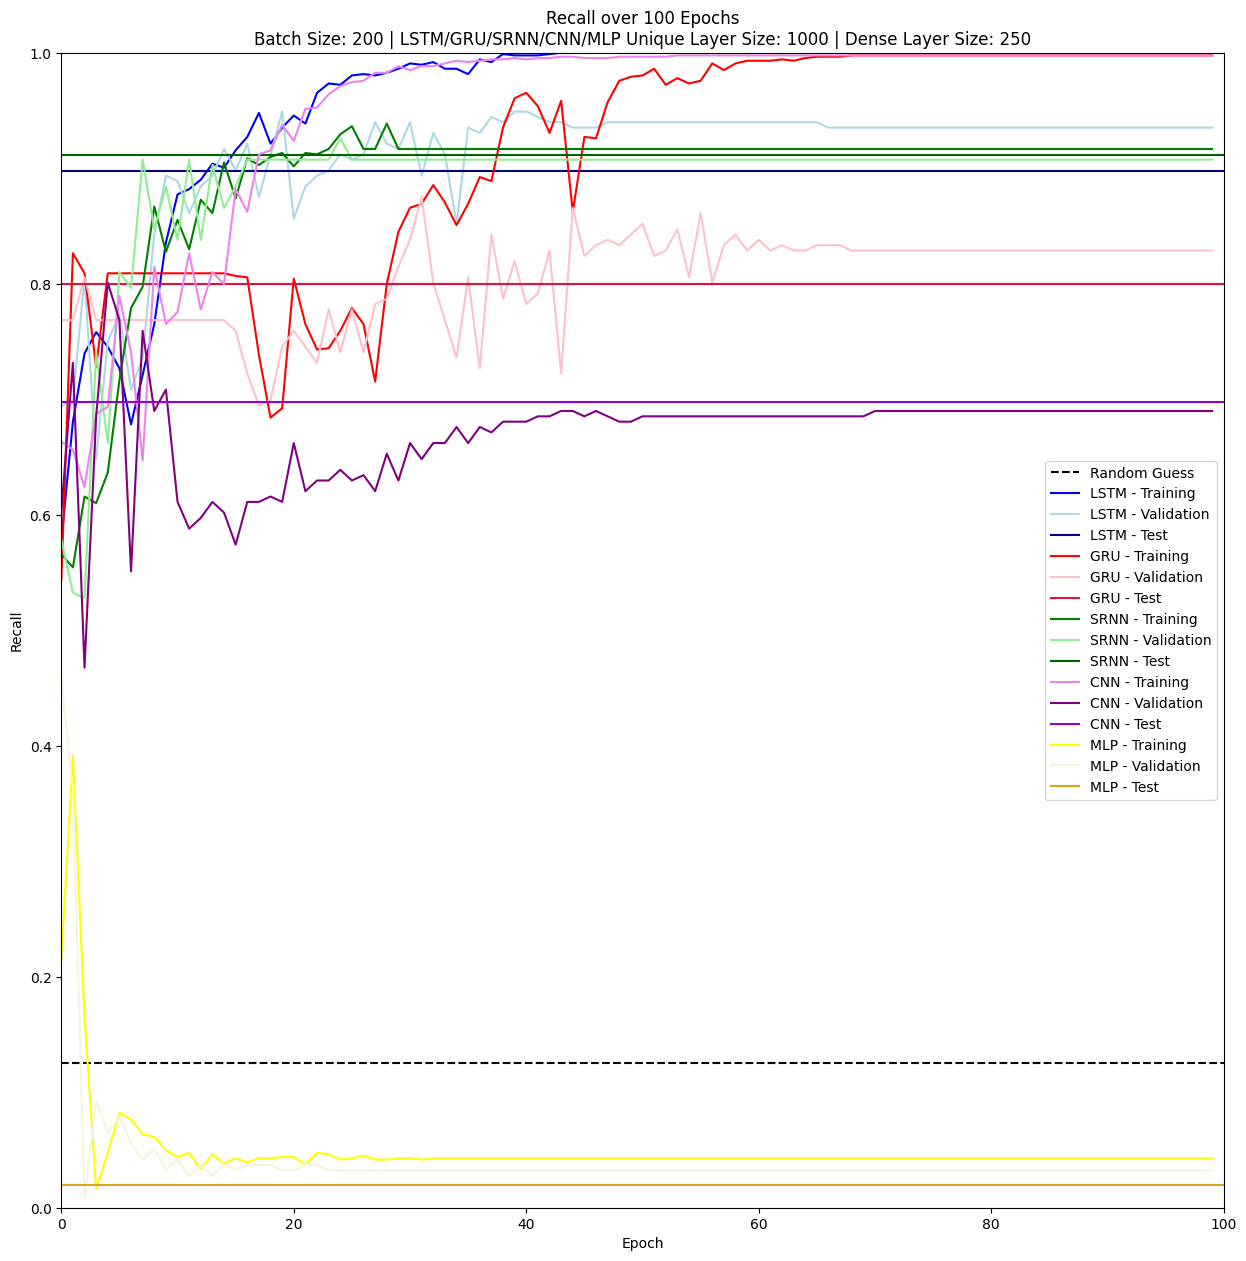

LSTM Test Recall: 0.8972222208976746
GRU Test Recall: 0.800000011920929
SimpleRNN Test Recall: 0.9111111164093018
CNN Test Recall: 0.6972222328186035
MLP Test Recall: 0.01944444514811039


In [46]:
# Comparison -- Recall
plt.figure(figsize=(15, 15))
plt.axhline(1/8, ls='dashed', label='Random Guess', color='black')

plt.plot(history_LSTM.history['Recall'], label='LSTM - Training', color='blue')
plt.plot(history_LSTM.history['val_Recall'], label='LSTM - Validation', color='lightblue')
plt.axhline(results_LSTM['Recall'], label='LSTM - Test', color='darkblue')

plt.plot(history_GRU.history['Recall'], label='GRU - Training', color='red')
plt.plot(history_GRU.history['val_Recall'], label='GRU - Validation', color='pink')
plt.axhline(results_GRU['Recall'], label='GRU - Test', color='crimson')

plt.plot(history_SRNN.history['Recall'], label='SRNN - Training', color='green')
plt.plot(history_SRNN.history['val_Recall'], label='SRNN - Validation', color='lightgreen')
plt.axhline(results_SRNN['Recall'], label='SRNN - Test', color='darkgreen')

plt.plot(history_CNN.history['Recall'], label='CNN - Training', color='violet')
plt.plot(history_CNN.history['val_Recall'], label='CNN - Validation', color='purple')
plt.axhline(results_CNN['Recall'], label='CNN - Test', color='darkviolet')

plt.plot(history_MLP.history['Recall'], label='MLP - Training', color='yellow')
plt.plot(history_MLP.history['val_Recall'], label='MLP - Validation', color='beige')
plt.axhline(results_MLP['Recall'], label='MLP - Test', color='goldenrod')

plt.title(f"Recall over {num_epochs} Epochs\nBatch Size: {batch_size} | LSTM/GRU/SRNN/CNN/MLP Unique Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.ylabel("Recall")
plt.xlabel("Epoch")
plt.xlim(0, 100)
plt.ylim(0, 1.0)
plt.legend()
plt.show()

print(f"LSTM Test Recall: {results_LSTM['Recall']}")
print(f"GRU Test Recall: {results_GRU['Recall']}")
print(f"SimpleRNN Test Recall: {results_SRNN['Recall']}")
print(f"CNN Test Recall: {results_CNN['Recall']}")
print(f"MLP Test Recall: {results_MLP['Recall']}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


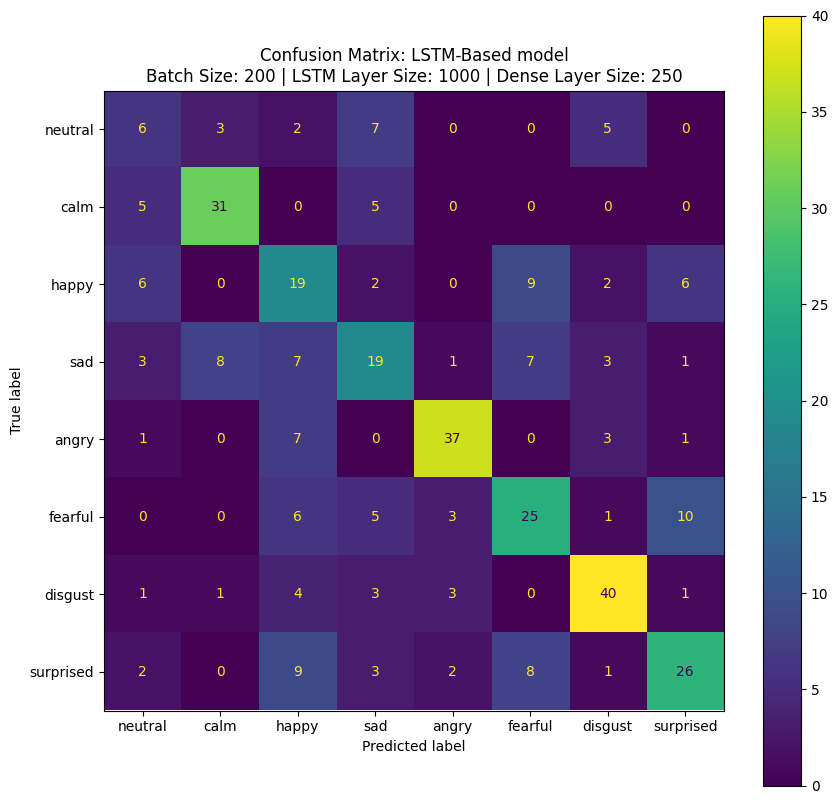

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


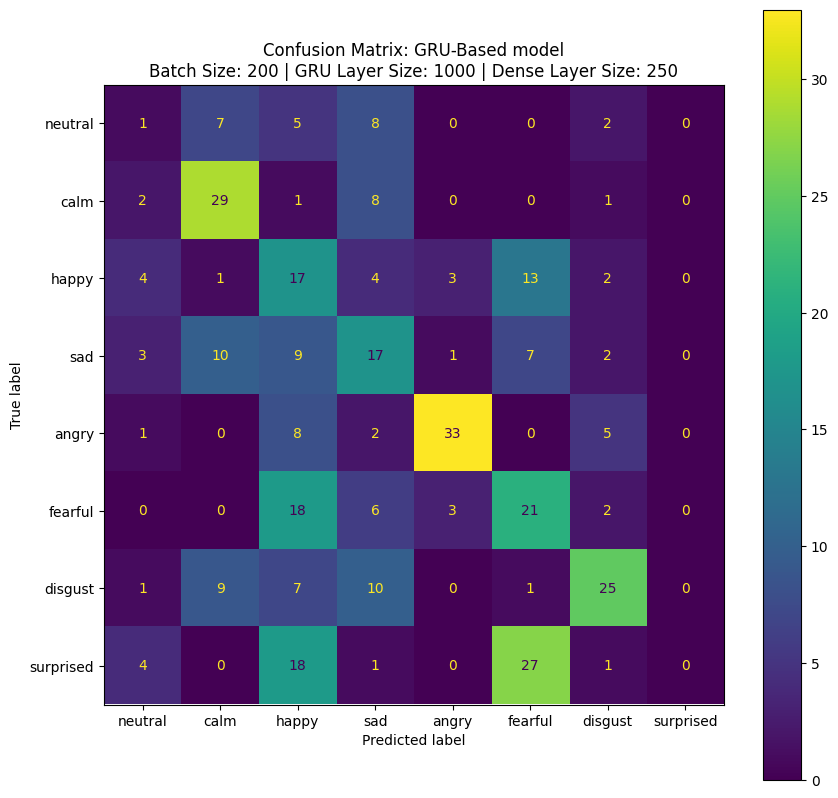

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


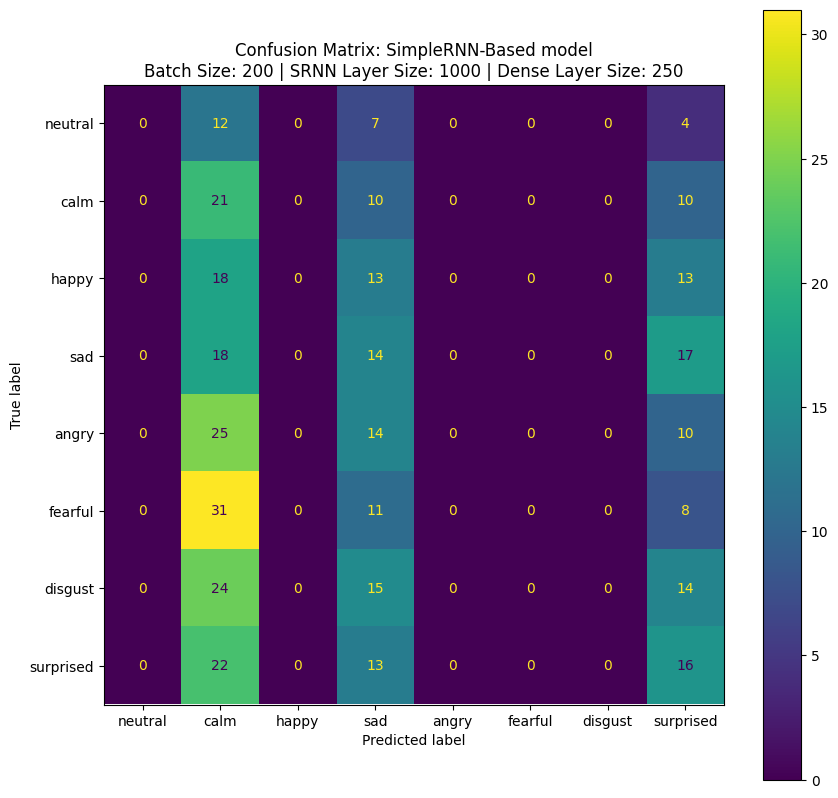

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


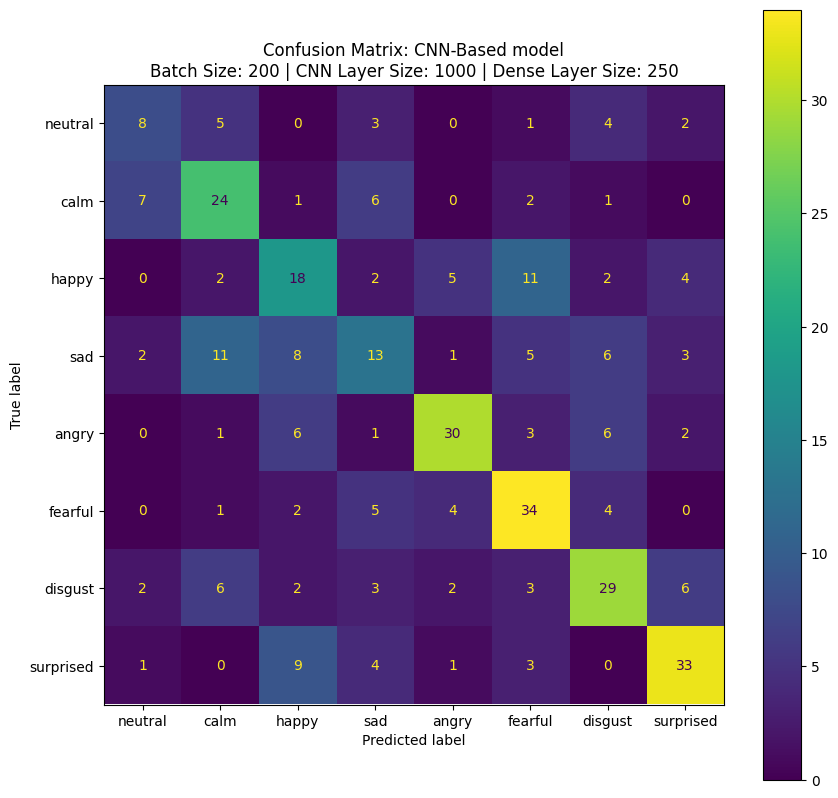

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


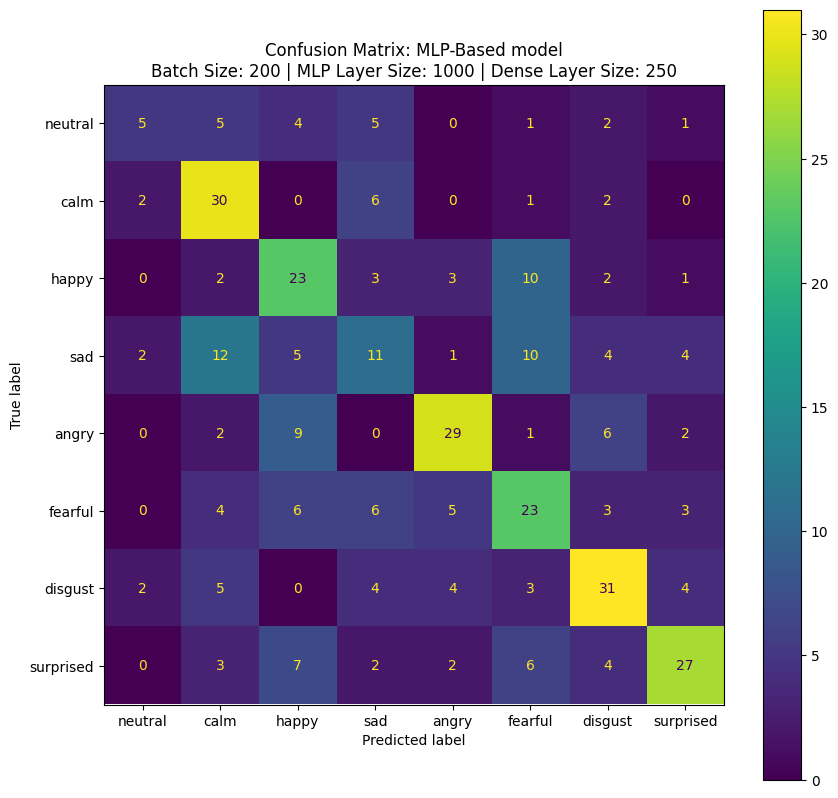

In [111]:
# Confusion Matrices
from sklearn.metrics import ConfusionMatrixDisplay

# Decode our original labels from the one-hot encoded labels
test_labels_decoded = ohc.inverse_transform(test_labels)
emotion_labels = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

# LSTM
pred_lstm = model_LSTM.predict(test_features)
pred_lstm_decoded = ohc.inverse_transform(pred_lstm)
fig, ax = plt.subplots(1, figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(test_labels_decoded, pred_lstm_decoded, display_labels=emotion_labels, ax=ax)
plt.title(f"Confusion Matrix: LSTM-Based model\nBatch Size: {batch_size} | LSTM Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.savefig("./plots/cm_LSTM.png")
plt.show()

# GRU
pred_gru = model_GRU.predict(test_features)
pred_gru_decoded = ohc.inverse_transform(pred_gru)
fig, ax = plt.subplots(1, figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(test_labels_decoded, pred_gru_decoded, display_labels=emotion_labels, ax=ax)
plt.title(f"Confusion Matrix: GRU-Based model\nBatch Size: {batch_size} | GRU Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.savefig("./plots/cm_GRU.png")
plt.show()

# SimpleRNN
pred_srnn = model_SRNN.predict(test_features)
pred_srnn_decoded = ohc.inverse_transform(pred_srnn)
fig, ax = plt.subplots(1, figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(test_labels_decoded, pred_srnn_decoded, display_labels=emotion_labels, ax=ax)
plt.title(f"Confusion Matrix: SimpleRNN-Based model\nBatch Size: {batch_size} | SRNN Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.savefig("./plots/cm_SRNN.png")
plt.show()

# CNN
pred_cnn = model_CNN.predict(test_features)
pred_cnn_decoded = ohc.inverse_transform(pred_cnn)
fig, ax = plt.subplots(1, figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(test_labels_decoded, pred_cnn_decoded, display_labels=emotion_labels, ax=ax)
plt.title(f"Confusion Matrix: CNN-Based model\nBatch Size: {batch_size} | CNN Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.savefig("./plots/cm_CNN.png")
plt.show()

# MLP
pred_mlp = model_MLP.predict(test_features)
pred_mlp_decoded = ohc.inverse_transform(pred_mlp)
fig, ax = plt.subplots(1, figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(test_labels_decoded, pred_mlp_decoded, display_labels=emotion_labels, ax=ax)
plt.title(f"Confusion Matrix: MLP-Based model\nBatch Size: {batch_size} | MLP Layer Size: {num_hidden_1} | Dense Layer Size: {num_hidden_2}")
plt.savefig("./plots/cm_MLP.png")
plt.show()

Dataload time: 0:00:56.223749

LSTM Training: 0:05:23.084693
GRU Training: 0:04:29.699446
SRNN Training: 0:02:53.675584
CNN Training: 0:00:35.567715
MLP Training: 0:01:04.275219
Total Fitting Time: 0:14:26.302658


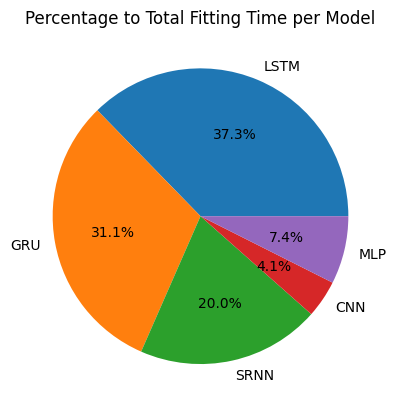

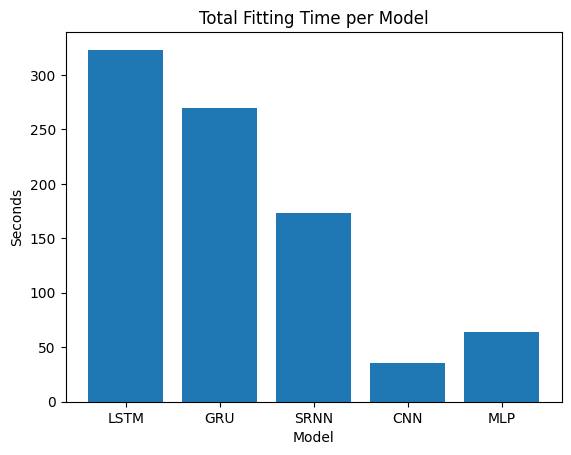

In [110]:
# Output time elapsed for large operations
print(f"Dataload time: {str(datetime.timedelta(seconds = runtime_dataload))}\n")
print(f"LSTM Training: {str(datetime.timedelta(seconds = runtime_LSTM))}")
print(f"GRU Training: {str(datetime.timedelta(seconds = runtime_GRU))}")
print(f"SRNN Training: {str(datetime.timedelta(seconds = runtime_SRNN))}")
print(f"CNN Training: {str(datetime.timedelta(seconds = runtime_CNN))}")
print(f"MLP Training: {str(datetime.timedelta(seconds = runtime_MLP))}")
print(f"Total Fitting Time: {datetime.timedelta(seconds=runtime_LSTM+runtime_GRU+runtime_SRNN+runtime_CNN+runtime_MLP)}")

fitting_times = [runtime_LSTM, runtime_GRU, runtime_SRNN, runtime_CNN, runtime_MLP]
labels = ['LSTM', 'GRU', 'SRNN', 'CNN', 'MLP']
plt.pie(fitting_times, labels=labels, autopct='%1.1f%%')
plt.title("Percentage to Total Fitting Time per Model")
plt.savefig("./plots/fitting_time_pie.png")
plt.show()

plt.bar(labels, fitting_times)
plt.title("Total Fitting Time per Model")
plt.xlabel("Model")
plt.ylabel("Seconds")
plt.savefig("./plots/fitting_time_per_model.png")
plt.show()

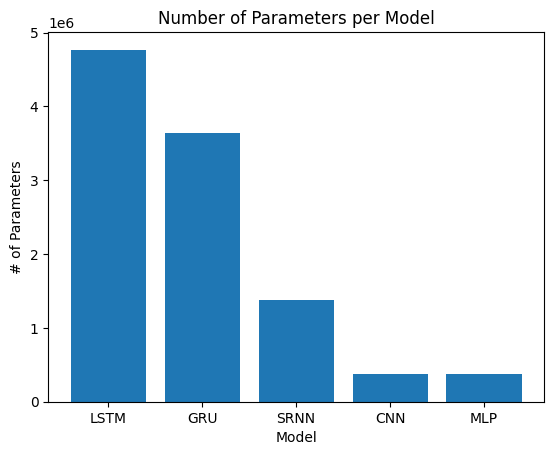

In [106]:
# Number of Parameters per Model

models = [model_LSTM, model_GRU, model_SRNN, model_CNN, model_MLP]
num_params = []
for each in models: num_params.append(keras.Layer.count_params(each))
plt.bar(labels, num_params)
plt.title("Number of Parameters per Model")
plt.xlabel("Model")
plt.ylabel("# of Parameters")
plt.savefig("./plots/parameters_per_model.png")
plt.show()

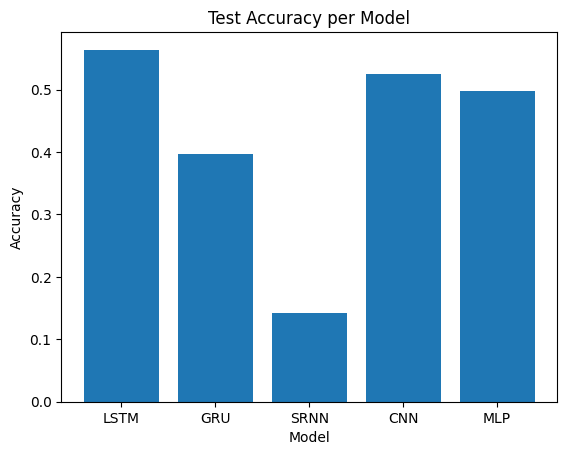

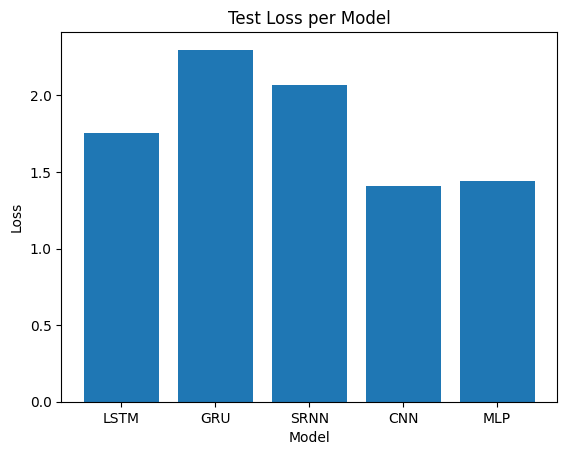

In [107]:
# Test Loss and Accuracy per Model
results = [results_LSTM, results_GRU, results_SRNN, results_CNN, results_MLP]
test_accuracy = list(map(lambda x: x.get('accuracy'), results))
plt.bar(labels, test_accuracy)
plt.title("Test Accuracy per Model")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.savefig("./plots/test_acc_per_model.png")
plt.show()

test_accuracy = list(map(lambda x: x.get('loss'), results))
plt.bar(labels, test_accuracy)
plt.title("Test Loss per Model")
plt.xlabel("Model")
plt.ylabel("Loss")
plt.savefig("./plots/test_loss_per_model.png")
plt.show()